In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import json
import scienceplots
import wandb
import pickle


from src.problem import Instance

import os 
os.environ["PATH"] += os.pathsep + '/home/bruno/texlive/2023/bin/x86_64-linux/'

plt.style.use(['science','bright'])
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

instances_dir = Path('../data/raw/')
results_dir = Path('../data/results/')
opts_dir = Path('../data/interim')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


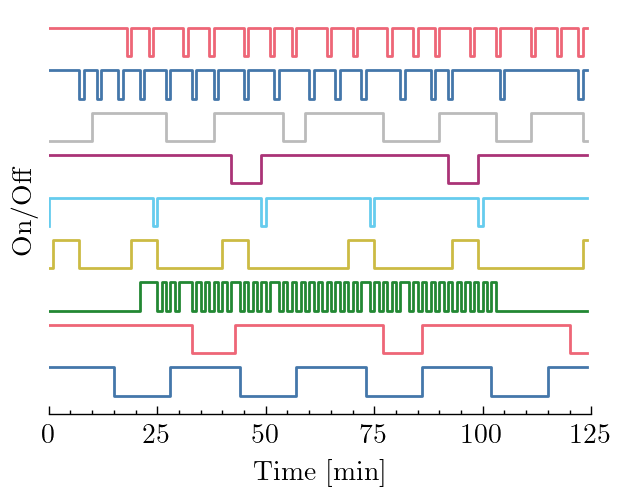

In [3]:
instance_fpath = next(instances_dir.glob('125_9_*.json'))
instance = Instance.from_file(instance_fpath)

opt_fp = opts_dir/(instance_fpath.name.replace('.json', '_opt.npz'))
obj, gap, runtime, X = np.load(opt_fp).values()

x = X[instance.vars_names.find('x(') >= 0]
x = x.reshape((instance.jobs, instance.T))

for i, j in enumerate(x):
    plt.step(np.arange(instance.T), j + i*1.5, label=i)

plt.xlim(0,instance.T)
plt.ylabel('On/Off')
plt.xlabel('Time [min]')

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks(np.linspace(0,125,6), )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.gcf().set_size_inches((6,6))

plt.tick_params(top=False, which='both')
plt.savefig('../schedule_example.pdf')
plt.show()

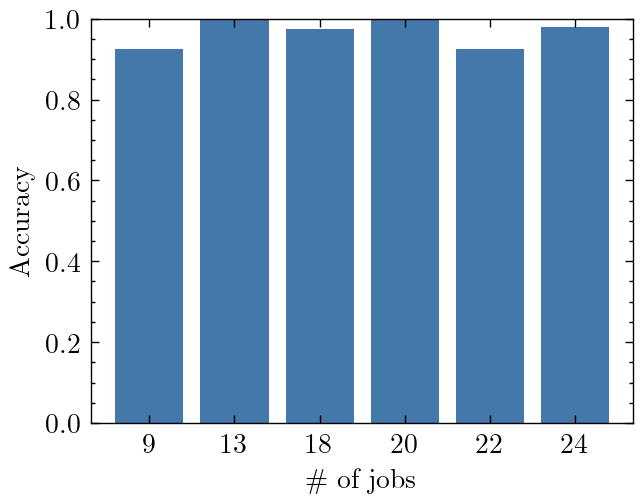

In [4]:
from collections import OrderedDict

accuracies = OrderedDict()
for size in [9,13,18,20,22,24]:
    runs = wandb.Api().runs(path='brunompac/sat-gnn', filters={'group': f'FeasClass-AcrossInstances-{size}'}, order='-created_at')
    run = runs[0]

    accuracies[size] = run.summary['val_loss_accuracy']

plt.bar(np.arange(len(accuracies.values())), accuracies.values(), tick_label=list(accuracies.keys()))

plt.xlabel('\# of jobs')
plt.ylabel('Accuracy')

plt.ylim(0,1)
# plt.minorticks_off()
plt.gcf().gca().set_xticks(list(), minor=True)
plt.savefig('../accuracy_classification_across_instances.pdf')
plt.show()

Optimals
0.28874673982384386


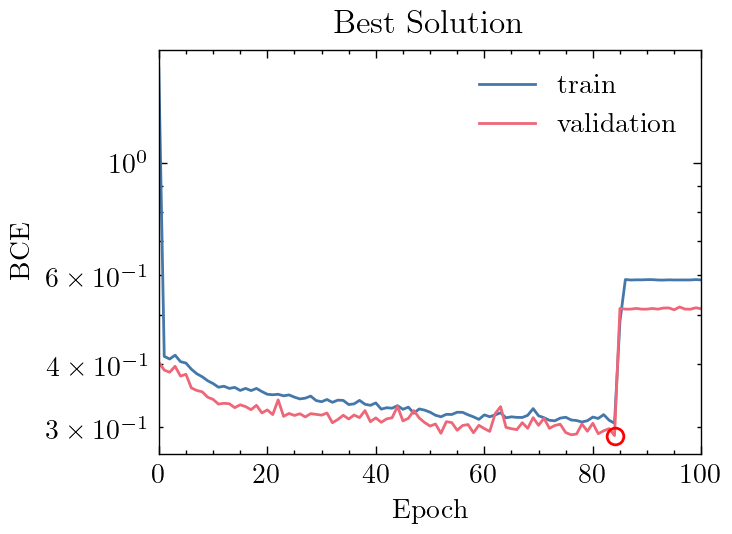

In [50]:
net_id = 'gbmooeqh'

api = wandb.Api()
run = api.run('brunompac/sat-gnn/'+net_id)
training_type = run.group[len('Best-'):]

df = run.history()
train_loss = df.train_loss.values
val_loss = df.val_loss.values

best_val_loss = run.summary['best_val']

fig, ax = plt.subplots()

ax.plot(train_loss, label='train')
ax.plot(val_loss, label='validation')
ax.plot(np.where(val_loss == best_val_loss)[0], [best_val_loss], 'o', color='r', fillstyle='none')

print(training_type)
print(best_val_loss)

plt.title('Best Solution')
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.legend()
plt.yscale('log')
plt.xlim(0,100)
plt.savefig('../training_curve_optimal.pdf')
plt.show()

MultiTarget
0.2451411026189783


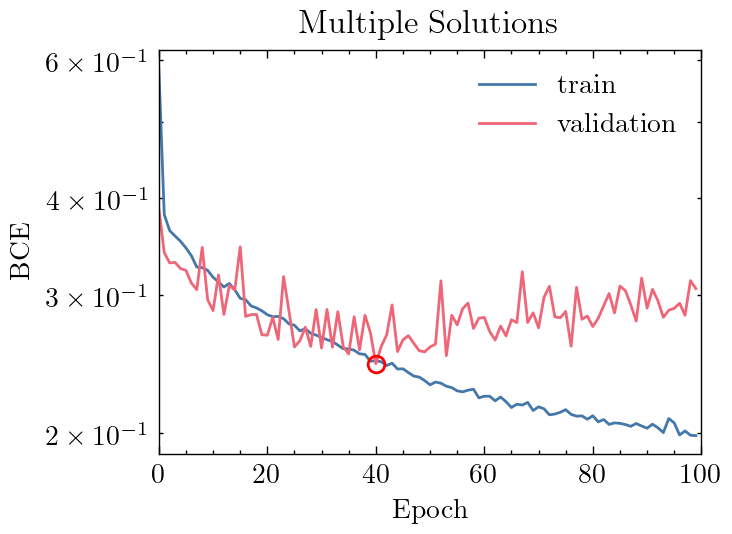

In [51]:
net_id = 'xae9giql'

api = wandb.Api()
run = api.run('brunompac/sat-gnn/'+net_id)
training_type = run.group[len('Best-'):]

df = run.history()
train_loss = df.train_loss.values
val_loss = df.val_loss.values

best_val_loss = run.summary['best_val']

fig, ax = plt.subplots()

ax.plot(train_loss * 500, label='train')
ax.plot(val_loss * 500, label='validation')
ax.plot(np.where(val_loss == best_val_loss)[0], [best_val_loss*500], 'o', color='r', fillstyle='none')

print(training_type)
print(best_val_loss * 500)

plt.title('Multiple Solutions')
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.legend()
plt.yscale('log')
plt.xlim(0,100)
plt.savefig('../training_curve_multi.pdf')
plt.show()

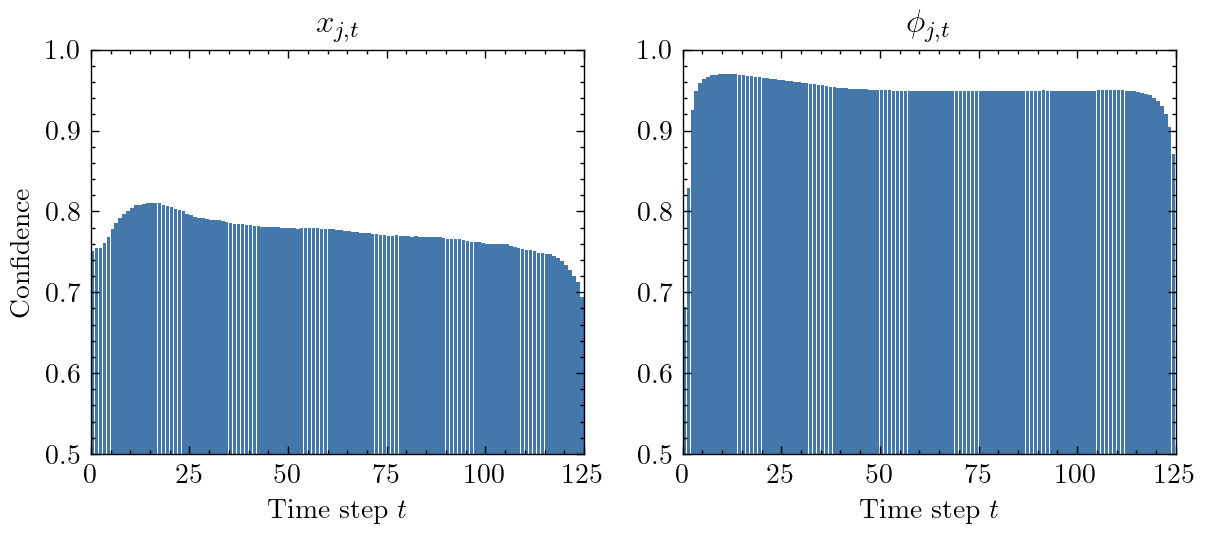

In [72]:
def var_conf_plot(conf, plot_title, filename=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.bar(np.arange(125), conf.mean(0), align='edge', width=.9)
    ax.set_xlim(0,125)
    ax.set_ylim(0.5,1)
    # plt.title('$x_{j,t}$ variables')
    ax.set_title(plot_title)
    # ax.set_ylabel('Confidence')
    ax.set_xlabel('Time step $t$')

    # if filename is not None:
    #     plt.savefig(filename, dpi=500)

    # plt.show()

with open('../gbmooeqh_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(7, 2.625)

var_conf_plot(X_conf, '$x_{j,t}$', ax=axs[0])
var_conf_plot(Phi_conf, '$\phi_{j,t}$', ax=axs[1])

axs[0].set_ylabel('Confidence')

fig.savefig('../optimals_confidence.pdf', dpi=500)
fig.show()

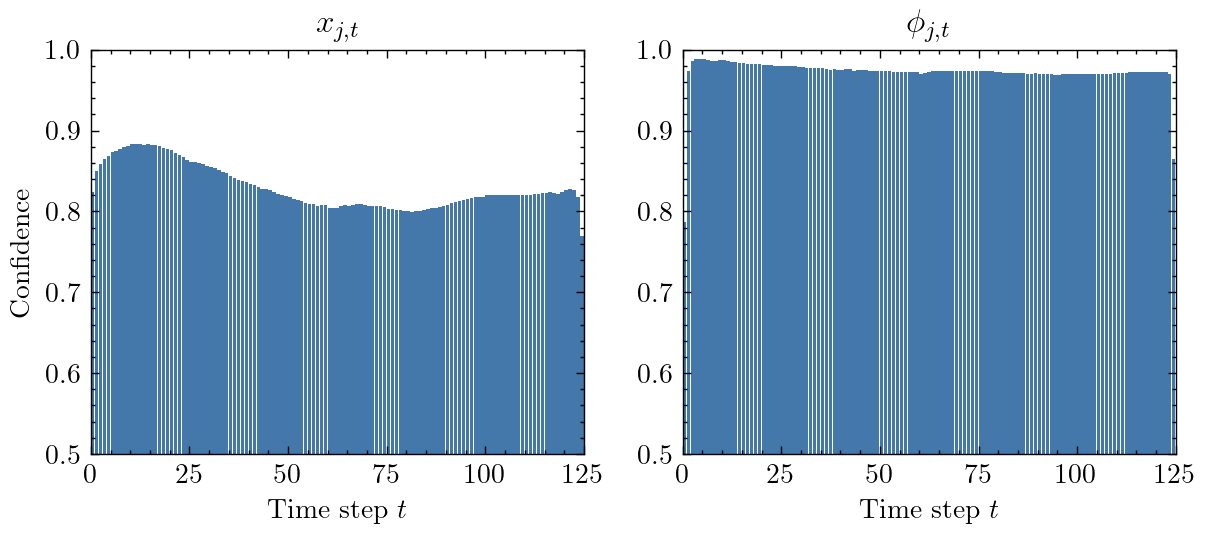

In [73]:
with open('../xae9giql_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(7, 2.625)

var_conf_plot(X_conf, '$x_{j,t}$', ax=axs[0])
var_conf_plot(Phi_conf, '$\phi_{j,t}$', ax=axs[1])

axs[0].set_ylabel('Confidence')

fig.savefig('../multiple_confidence.pdf', dpi=500)
fig.show()

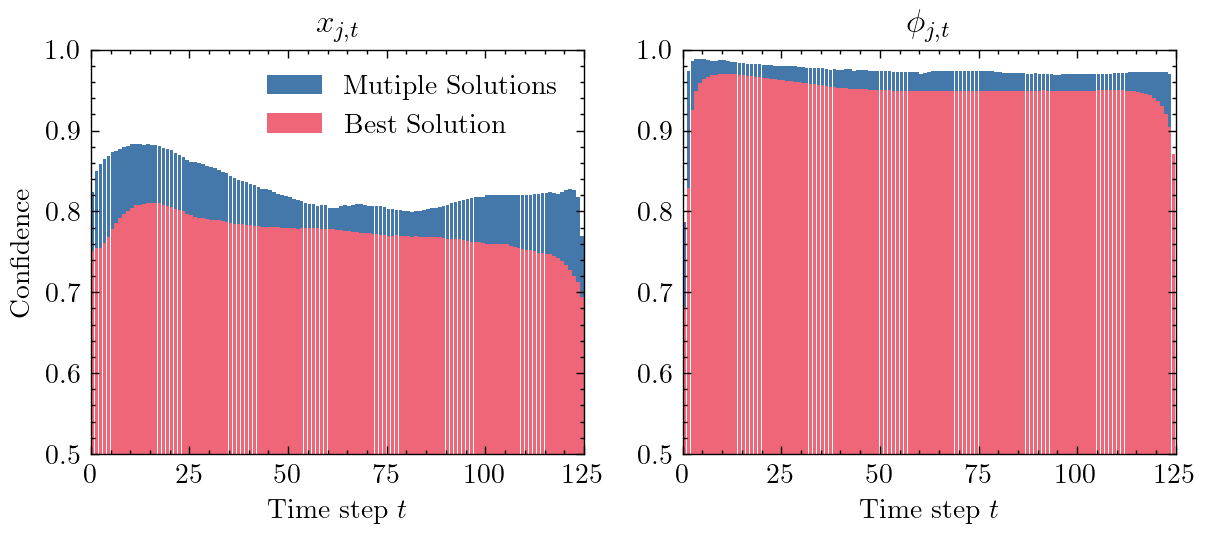

In [71]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(7, 2.625)

with open('../xae9giql_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

axs[0].bar(np.arange(125), X_conf.mean(0), align='edge', width=.9, label='Mutiple Solutions')
axs[1].bar(np.arange(125), Phi_conf.mean(0), align='edge', width=.9, label='Mutiple Solutions')

with open('../gbmooeqh_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

axs[0].bar(np.arange(125), X_conf.mean(0), align='edge', width=.9, label='Best Solution')
axs[1].bar(np.arange(125), Phi_conf.mean(0), align='edge', width=.9, label='Best Solution')

axs[0].set_xlim(0,125)
axs[0].set_ylim(0.5,1)
axs[0].set_title('$x_{j,t}$')
axs[0].set_xlabel('Time step $t$')

axs[1].set_xlim(0,125)
axs[1].set_ylim(0.5,1)
axs[1].set_title('$\phi_{j,t}$')
axs[1].set_xlabel('Time step $t$')

axs[0].set_ylabel('Confidence')

axs[0].legend()
fig.savefig('../confidences.pdf', dpi=500)
fig.show()